**Previsão de Demanda em Vendas: Análise de Sazonalidades e Modelagem de Séries Temporais**

Introdução:
O objetivo deste projeto é desenvolver um modelo de previsão de demanda em vendas utilizando técnicas de análise de séries temporais. A previsão de vendas é uma parte crucial da gestão de estoque e tomada de decisões em negócios de varejo. O modelo será construído e avaliado usando dados históricos de vendas, informações de lojas e fatores sazonais.

Carregamento e Análise dos Dados
Nesta parte, carrega os dados de features, vendas e lojas em DataFrames separados e visualizamos as informações básicas. A combinação dos DataFrames é realizada usando chaves comuns, como datas e lojas, e os dados são mesclados para uma análise conjunta.

In [146]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA as ARIMA_new
from sklearn.metrics import mean_absolute_error, mean_squared_error





In [147]:
# Carregar os arquivos CSV em DataFrames
features_df = pd.read_csv('features data set.csv')
sales_df = pd.read_csv('sales data-set.csv')
stores_df = pd.read_csv('stores data-set.csv')


In [148]:

# Juntar os DataFrames usando chaves comuns, como datas e lojas
merged_df = pd.merge(sales_df, features_df, on=['Store', 'Date'], how='inner')
merged_df = pd.merge(merged_df, stores_df, on=['Store'], how='inner')

# Converter a coluna 'Date' para formato datetime (dia/mês/ano)
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%d/%m/%Y')

# Exibir informações básicas sobre os DataFrames
print("Features DataFrame:")
print(features_df.head())
print("\nSales DataFrame:")
print(sales_df.head())
print("\nStores DataFrame:")
print(stores_df.head())
print("\nMerged DataFrame:")
print(merged_df.head())

Features DataFrame:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  05/02/2010        42.31       2.572        NaN        NaN   
1      1  12/02/2010        38.51       2.548        NaN        NaN   
2      1  19/02/2010        39.93       2.514        NaN        NaN   
3      1  26/02/2010        46.63       2.561        NaN        NaN   
4      1  05/03/2010        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  

Sales DataFrame:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  05/02/2010      24924.5

 Análise de Tendências Mensais de Vendas
Nesta seção, explora-se as tendências mensais de vendas por loja. Utilizamos gráficos de linhas para visualizar como as vendas variam ao longo dos meses para cada loja, identificando padrões sazonais e flutuações.

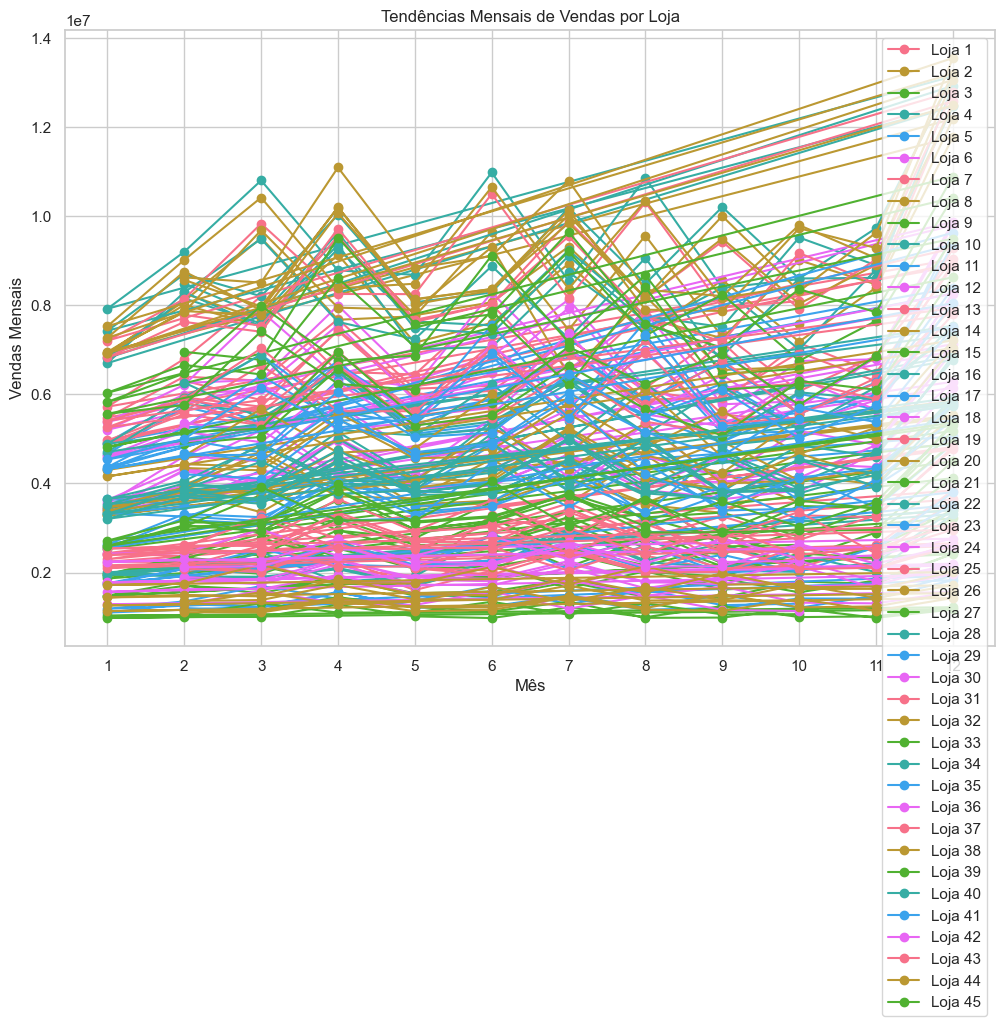

In [150]:
# Converter a coluna 'Date' para formato datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%d/%m/%Y')

# Extrair as informações de ano e mês da coluna 'Date'
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month

# Visualizar tendências mensais de vendas por loja
plt.figure(figsize=(12, 8))
sns.set_palette("husl")
for store in merged_df['Store'].unique():
    store_data = merged_df[merged_df['Store'] == store]
    monthly_sales = store_data.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
    plt.plot(monthly_sales['Month'], monthly_sales['Weekly_Sales'], marker='o', label=f'Loja {store}')
plt.title('Tendências Mensais de Vendas por Loja')
plt.xlabel('Mês')
plt.ylabel('Vendas Mensais')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()


Sazonalidade Semanal de Vendas
Aqui, investigando a sazonalidade semanal de vendas, agrupando os dados por dia da semana e calculando as vendas médias para cada dia. Um gráfico de barras é usado para ilustrar as médias de vendas semanais em relação aos diferentes dias da semana.



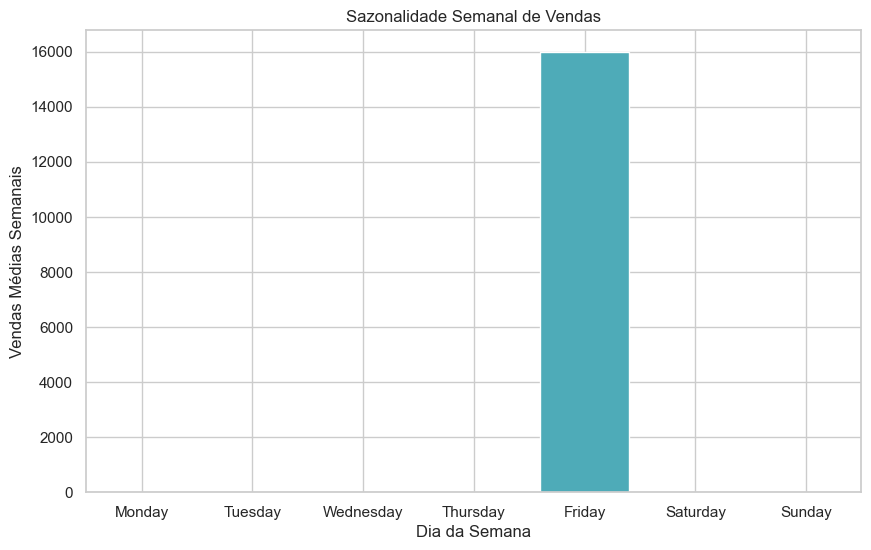

In [151]:
# Identificar sazonalidades semanais
merged_df['Weekday'] = merged_df['Date'].dt.day_name()
weekday_sales = merged_df.groupby(['Weekday'])['Weekly_Sales'].mean().reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 6))
sns.barplot(x='Weekday', y='Weekly_Sales', data=weekday_sales, order=weekday_order)
plt.title('Sazonalidade Semanal de Vendas')
plt.xlabel('Dia da Semana')
plt.ylabel('Vendas Médias Semanais')
plt.grid(True)
plt.show()


Análise de Vendas por Departamento
Explorando as vendas médias por departamento usando um gráfico de barras. Isso nos ajuda a entender como as vendas variam em diferentes departamentos.

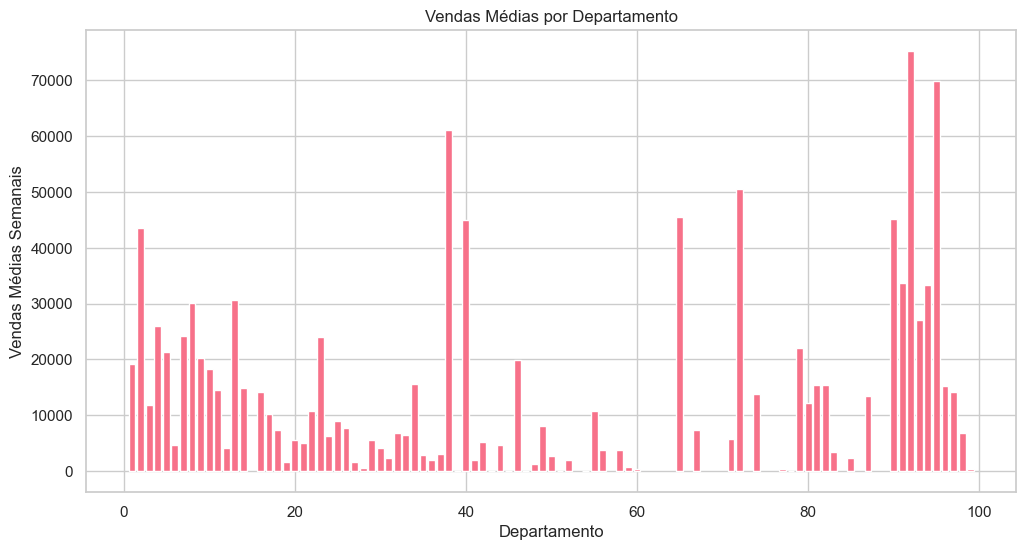

In [152]:
# Analisar vendas por departamento
dept_sales = merged_df.groupby(['Dept'])['Weekly_Sales'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(dept_sales['Dept'], dept_sales['Weekly_Sales'])
plt.title('Vendas Médias por Departamento')
plt.xlabel('Departamento')
plt.ylabel('Vendas Médias Semanais')
plt.grid(True)
plt.show()


Distribuição de Vendas Semanais
Visualizando a distribuição das vendas semanais usando um histograma. Isso nos ajuda a entender a variação nas vendas e a identificar possíveis outliers.

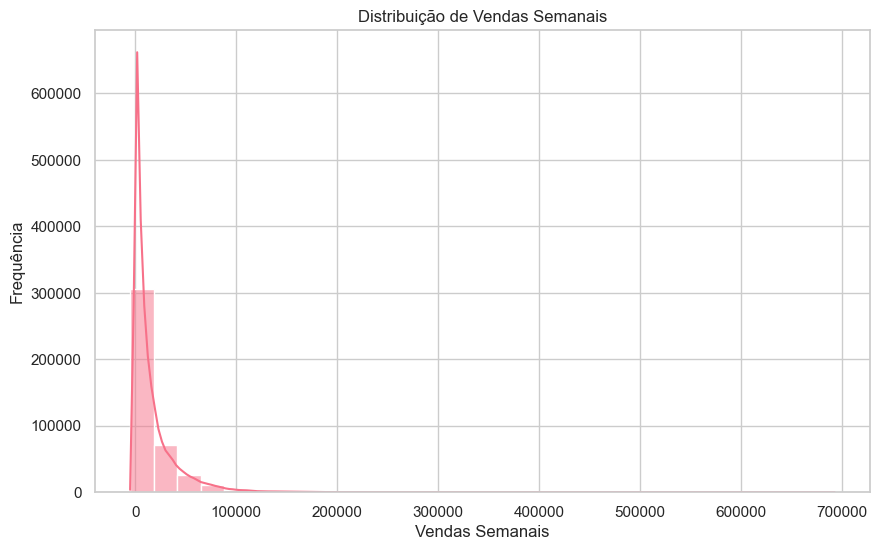

In [153]:
# Explorar distribuição de vendas
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='Weekly_Sales', bins=30, kde=True)
plt.title('Distribuição de Vendas Semanais')
plt.xlabel('Vendas Semanais')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

Sazonalidade por Departamento
Analisando a sazonalidade mensal das vendas por departamento, criando um gráfico de linhas para cada departamento. Isso nos ajuda a identificar padrões sazonais específicos de cada departamento.

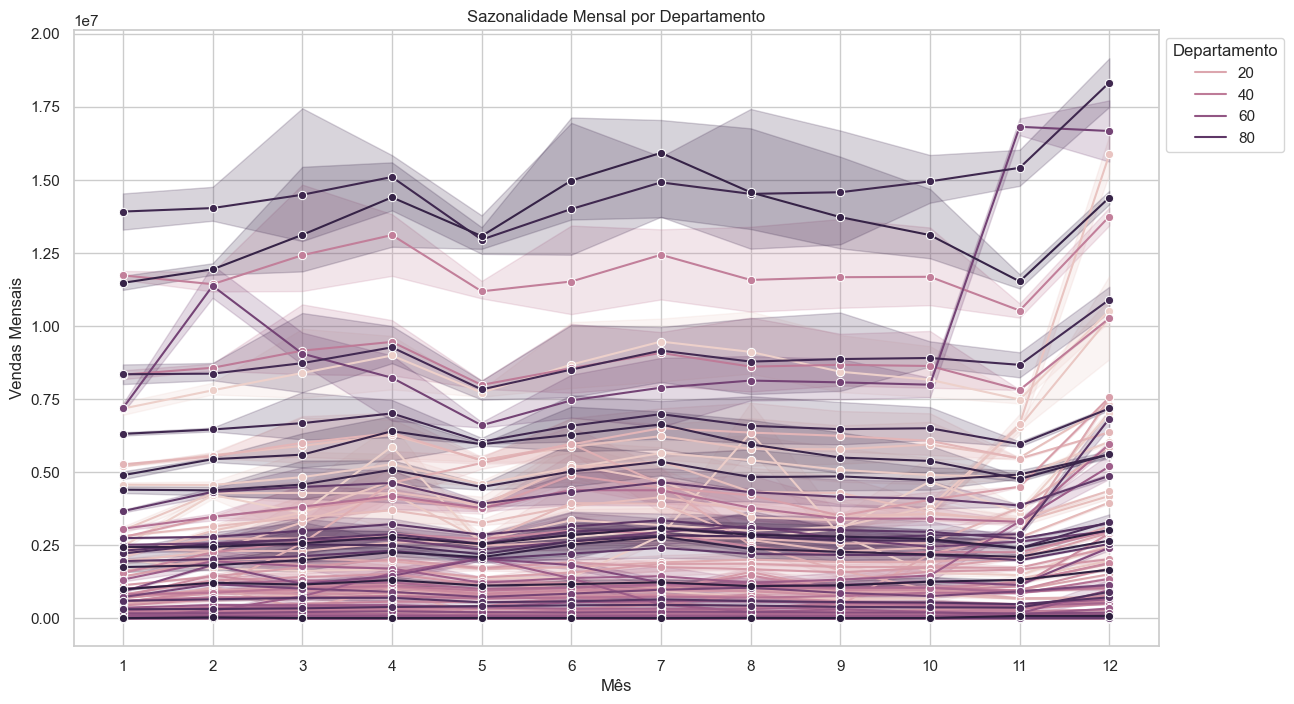

In [154]:

# Identificar sazonalidade por departamento
dept_monthly_sales = merged_df.groupby(['Dept', 'Year', 'Month'])['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(14, 8))
sns.lineplot(data=dept_monthly_sales, x='Month', y='Weekly_Sales', hue='Dept', marker='o')
plt.title('Sazonalidade Mensal por Departamento')
plt.xlabel('Mês')
plt.ylabel('Vendas Mensais')
plt.xticks(range(1, 13))
plt.legend(title='Departamento', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [155]:
# Pré-processamento de Dados
merged_df.fillna(0, inplace=True)  # Preencher valores ausentes com 0
le = LabelEncoder()
merged_df['Type'] = le.fit_transform(merged_df['Type'])  # Codificar tipo de loja
scaler = StandardScaler()
numeric_vars = ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
merged_df[numeric_vars] = scaler.fit_transform(merged_df[numeric_vars])


In [156]:
# Dividir os dados em conjuntos de treinamento e teste
train_ratio = 0.8
train_size = int(train_ratio * len(merged_df))
train_data = merged_df[:train_size]
test_data = merged_df[train_size:]


Modelagem de Séries Temporais com SARIMAX
Nesta etapa, realiza-se a modelagem das séries temporais usando o modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors). Ajustamos o modelo aos dados de treinamento e fazemos previsões para os dados de teste.

In [157]:
# Modelagem usando SARIMAX
train_sales = train_data.groupby(['Date'])['Weekly_Sales'].sum().reset_index()
train_sales.set_index('Date', inplace=True)


In [159]:
# Ajustar modelo SARIMAX
order = (1, 1, 1)  # Ordem (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Or
# Selecionar os valores reais das vendas semanais nos dados de teste
actual_sales = test_data.groupby(['Date'])['Weekly_Sales'].sum()


Avaliação do Modelo
Calcula-se métricas de avaliação, como o Erro Médio Absoluto (MAE), Erro Quadrático Médio (MSE) e Erro Percentual Absoluto Médio (MAPE), para avaliar o desempenho do modelo nas previsões.



In [160]:

# Calcular métricas de avaliação
mae = mean_absolute_error(actual_sales, predictions)
mse = mean_squared_error(actual_sales, predictions)
mape = np.mean(np.abs((actual_sales - predictions) / actual_sales)) * 100

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MAPE: {mape:.2f}%')

MAE: 32041075.75
MSE: 1118501998679512.12
MAPE: 432.97%


 Ajuste de Hiperparâmetros
Realiza uma busca por hiperparâmetros otimizados para o modelo SARIMAX, explorando diferentes combinações de ordens para os termos autoregressivos, integrados e de médias móveis, tanto para os termos regulares quanto para os sazonais.

In [161]:
# Ajuste de Hiperparâmetros:
from itertools import product

# Definir possíveis valores para os hiperparâmetros
p_values = range(0, 3)  # Ordem p
d_values = range(1, 3)  # Ordem d
q_values = range(0, 3)  # Ordem q
P_values = range(0, 3)  # Ordem sazonal P
D_values = range(1, 3)  # Ordem sazonal D
Q_values = range(0, 3)  # Ordem sazonal Q
S_values = [12]  # Frequência sazonal

In [162]:
# Criar todas as combinações de hiperparâmetros possíveis
hyperparameters = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values))

best_mape = float('inf')
best_params = None

for params in hyperparameters:
    try:
        model = sm.tsa.SARIMAX(train_sales, order=params[:3], seasonal_order=params[3:])
        model_fit = model.fit()
        predictions = model_fit.predict(start=start_date, end=end_date, dynamic=False)
        mape = np.mean(np.abs((actual_sales - predictions) / actual_sales)) * 100
        if mape < best_mape:
            best_mape = mape
            best_params = params
    except:
        continue

print(f'Best MAPE: {best_mape:.2f}%')
print(f'Best Hyperparameters: {best_params}')

C:\Users\T26432\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\T26432\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\T26432\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\T26432\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2

Best MAPE: 431.09%
Best Hyperparameters: (0, 2, 1, 1, 2, 1, 12)


Previsões Futuras
Ajusta o modelo SARIMAX usando todos os dados disponíveis e fazemos previsões futuras para um determinado número de períodos.

In [ ]:
# Ajustar para fazer previsões futuras de demanda com base em dados futuros de sazonalidades e eventos especiais
# Definir o período futuro para as previsões
future_periods = 10  # Por exemplo, previsões para os próximos 10 períodos

# Gerar datas futuras com base no último período dos dados de treinamento
future_dates = pd.date_range(start=end_date, periods=future_periods + 1, freq='W-FRI')[1:]

# Criar um DataFrame para armazenar as previsões futuras
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted_Weekly_Sales'])

# Ajustar o modelo SARIMAX usando todos os dados disponíveis
full_model = sm.tsa.SARIMAX(merged_df.groupby(['Date'])['Weekly_Sales'].sum(), order=best_params[:3], seasonal_order=best_params[3:])
full_model_fit = full_model.fit()

# Fazer previsões futuras
future_predictions['Predicted_Weekly_Sales'] = full_model_fit.predict(start=end_date, end=future_dates[-1], dynamic=False)


Visualiza as previsões futuras junto com os dados reais de vendas, destacando as tendências e sazonalidades nas previsões.


In [ ]:
# Visualizar as previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(train_sales.index, train_sales['Weekly_Sales'], label='Dados de Treinamento')
plt.plot(test_data['Date'], test_data['Weekly_Sales'], label='Dados de Teste', alpha=0.5)
plt.plot(predictions.index, predictions, label='Previsões no Teste', linestyle='dashed')
plt.plot(future_predictions.index, future_predictions['Predicted_Weekly_Sales'], label='Previsões Futuras', linestyle='dotted')
plt.title('Previsões Futuras de Vendas usando SARIMAX')
plt.xlabel('Data')
plt.ylabel('Vendas Semanais')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Visualizar as previsões futuras em formato tabular
print(future_predictions)

# Criar visualizações atraentes para comparar as previsões de demanda futura com os dados reais
plt.figure(figsize=(12, 6))
plt.plot(train_sales.index, train_sales['Weekly_Sales'], label='Dados de Treinamento')
plt.plot(test_data['Date'], test_data['Weekly_Sales'], label='Dados de Teste', alpha=0.5)
plt.plot(future_predictions.index, future_predictions['Predicted_Weekly_Sales'], label='Previsões Futuras', linestyle='dotted')
plt.title('Previsões Futuras de Vendas com Tendências e Sazonalidades')
plt.xlabel('Data')
plt.ylabel('Vendas Semanais')
plt.legend()
plt.grid(True)
plt.show()

Conclusão:
Neste projeto, construímos um modelo de previsão de demanda em vendas utilizando a análise de séries temporais e o modelo SARIMAX. Exploramos padrões sazonais e tendências nos dados, ajustamos o modelo aos dados de treinamento e avaliamos seu desempenho nas previsões de vendas futuras.